In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import pandas as pd

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.utils import class_weight

from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

2022-11-30 00:35:20.626252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 00:35:20.834228: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-30 00:35:21.590161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-30 00:35:21.590241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Model to combine the output of Naive Bayes Classifier, and read the pooled output from BERT Model

In [2]:
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

2022-11-30 00:35:25.773092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-30 00:35:25.801035: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-30 00:35:25.801063: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-30 00:35:25.801678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep

In [3]:
# bring in the data
questions_data = pd.read_csv("questions_nb_predictions.csv")

In [4]:
questions_data.head(2)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count,SPLIT,NB_prediction
0,0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70,TRAIN,0.400395
1,1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38,TRAIN,0.287295


In [5]:
# from sklearn.utils import shuffle
# questions_data = shuffle(questions_data)
# questions_data = questions_data.head(500) # just doing small subset to make it work at first

In [6]:
questions_data['has_positive_answer'].value_counts()

1    407222
0    200060
Name: has_positive_answer, dtype: int64

In [7]:
train = questions_data.loc[questions_data['SPLIT'] == "TRAIN"]
test = questions_data.loc[questions_data['SPLIT'] == "TEST"]

In [8]:
train_titles = list(train['Title'])
train_nb_preds = list(train['NB_prediction'])
train_labels = list(train['has_positive_answer'])

test_titles = list(test['Title'])
test_nb_preds = list(test['NB_prediction'])
test_labels = list(test['has_positive_answer'])

In [9]:
max_length = 25

In [10]:
x_train_bert = bert_tokenizer(train_titles,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

x_train_nb = tf.convert_to_tensor(train_nb_preds)
y_train_labels = tf.convert_to_tensor(train_labels)

In [11]:
x_test_bert = bert_tokenizer(test_titles,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
x_test_nb = tf.convert_to_tensor(test_nb_preds)

y_test_labels = tf.convert_to_tensor(test_labels)

In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels.numpy()), y=y_train_labels.numpy())
class_weights_dict = {}
for i in range(0,2):
    class_weights_dict[i] = class_weights[i]
class_weights_dict

{0: 1.5165523114856558, 1: 0.7459293015965245}

In [13]:
def create_bert_classification_model(bert_model,
                                     learning_rate=0.00005):

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      
    bert_out = bert_model(bert_inputs)
    
    pooled_token = bert_out[1]
    
    # first concatenate the nb_prediction w/ pooled token, prior to dense layer
    
    # nb prediction input layer
    nb_prediction = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='nb_prediction_layer')
    
    concatenated_layers = concatenate([pooled_token, nb_prediction])
    
    # after concatenating, put through large dense layer
    
    dense_layer = tf.keras.layers.Dense(300, activation='relu', name='hidden_layer')(concatenated_layers)
    
    dropout = tf.keras.layers.Dropout(0.3)(dense_layer)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, nb_prediction], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [14]:
bert_classification_model = create_bert_classification_model(bert_model)

In [15]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train_bert.input_ids, x_train_bert.token_type_ids, x_train_bert.attention_mask, x_train_nb],
    y_train_labels,
    validation_data=([x_test_bert.input_ids, x_test_bert.token_type_ids, x_test_bert.attention_mask, x_test_nb], y_test_labels),
    batch_size=32,
    epochs=2,
    class_weight=class_weights_dict
)  

Epoch 1/2
13801/13801 [==============================] - 21605s 2s/step - loss: 0.6622 - accuracy: 0.6111 - val_loss: 0.6384 - val_accuracy: 0.6462
Epoch 2/2
13801/13801 [==============================] - 22454s 2s/step - loss: 0.6327 - accuracy: 0.6583 - val_loss: 0.6621 - val_accuracy: 0.6238


In [16]:
y_pred_raw = bert_classification_model.predict([x_test_bert.input_ids, x_test_bert.token_type_ids, x_test_bert.attention_mask, x_test_nb])
y_pred = (y_pred_raw > 0.5).astype(int)

5178/5178 [==============================] - 1840s 355ms/step


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test_labels, y_pred)

<AxesSubplot:>

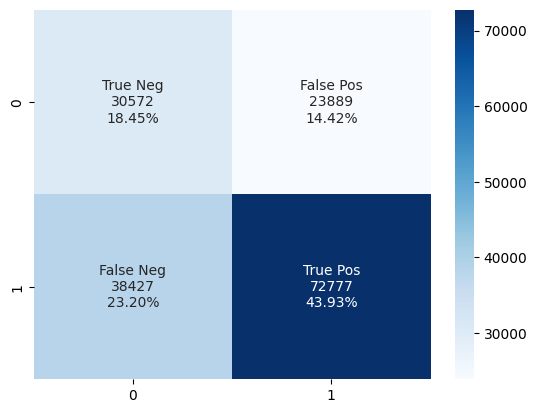

In [18]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

In [19]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test_labels,  y_pred_raw)
auc = metrics.roc_auc_score(y_test_labels, y_pred_raw)

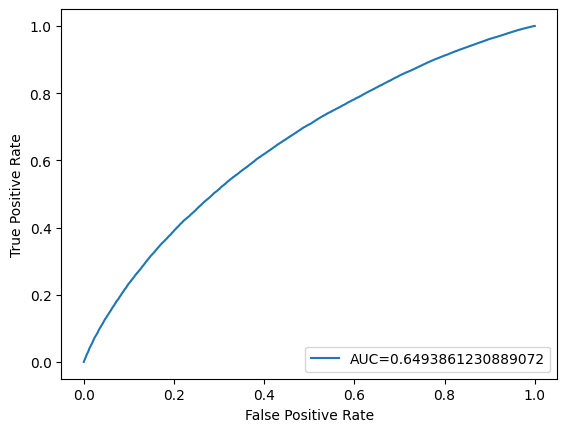

In [20]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred)
recall = recall_score(y_test_labels, y_pred)

In [22]:
print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.7002164814547553
precision score is: 0.7528707094531687
recall score is: 0.65444588324161


In [23]:
all_titles = list(questions_data['Title'])
all_nb_preds = list(questions_data['NB_prediction'])

In [24]:
x_all_bert = bert_tokenizer(all_titles,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
x_all_nb = tf.convert_to_tensor(all_nb_preds)

In [25]:
all_predictions = bert_classification_model.predict([x_all_bert.input_ids, x_all_bert.token_type_ids, x_all_bert.attention_mask, x_all_nb])

# y_pred_raw = bert_classification_model.predict([x_test_bert.input_ids, x_test_bert.token_type_ids, x_test_bert.attention_mask, x_test_nb])

 4144/18978 [=====>........................] - ETA: 1:52:03

KeyboardInterrupt: 